In [1]:
import os
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

### 绘制混淆矩阵

有些概念比较混淆，例如准确率、精准率等。

准确率(accurary)：（正确预测0的个数+正确预测1的个数）/ 所有样本数

精确率(precision)=查准率：预测为1中真实为1的样本数 / 预测为1的样本数

真阳性率(True Positive Rate, TPR)=灵敏度(sensitivity)=敏感度=召回率(recall)=标签1的查全率：正确预测1的个数 / 实际1的样本数

假阳性率(False Positive Rate, FPR)=1-真阴率 ：预测为0中真实为1的样本数 / 实际0的样本数

真阴性率(True Negative Rate,TNR)=特异度(specificity)=标签0的查全率：正确预测0的个数 / 实际0的样本数

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,train_test_split
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, ScalarFormatter
import numpy as np
import pandas as pd

# Set the global font same as the sci-paper.
plt.rc('font',family='Times New Roman')
# 修改公式中默认字体
plt.rcParams['mathtext.default'] = 'regular'
# Set the figure size
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.labelsize'] = 42

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['lines.color'] = 'r'

# 定义字体font1
font1 = {'family': 'Times New Roman',
'weight': 'normal',
'size': 15,
}


from math import sqrt

# Calculate the confidence interval of the 
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# Define the ROC Plot on the subplot(ax).
def roc_plot_inside(y_true, y_score, label, ax, positive=1):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    fpr,tpr,threshold = roc_curve(y_true, y_score, pos_label=positive) ###计算真正率和假                            
    roc_auc = auc(fpr,tpr) ###计算auc的值
    roc_auc_low, roc_auc_up = roc_auc_ci(y_true, y_score, positive)
    if roc_auc_up > 1.0:
        roc_auc_up = 1.0
    ax.plot(fpr, tpr, 
             lw=2, label='{3} (AUC={0:0.3f},95%CI:({1:0.3f}-{2:0.3f}))'.format(roc_auc,roc_auc_low,roc_auc_up,label)) ###假正率为横坐标，真正率为纵坐标做曲线
    
    
# 计算混淆矩阵
from sklearn.metrics import confusion_matrix    #导入计算混淆矩阵的包
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from pylab import mpl
mpl.rcParams['font.family'] = 'Times New Roman'
import seaborn as sns #导入包

# To draw the  confusion-matrix based on the truth and predicted label.
# out_fig: the output fig name(include path);
def confusion_matrix_plot(true_label, predict, out_fig, fig_title):
    C = confusion_matrix(true_label, predict)
    fig, ax = plt.subplots(figsize=(12,10))
    df=pd.DataFrame(C)
    sns.heatmap(df, fmt='g', annot=True, cmap='Blues', ax=ax, annot_kws={"size":35})
    ax.set_xlabel('Predict',fontsize=42, color='k') #x轴label的文本和字体大小
    ax.set_ylabel('True',fontsize=42, color='k') #y轴label的文本和字体大小
    ax.tick_params(labelsize=35)
    #设置colorbar的刻度字体大小
    cax = plt.gcf().axes[-1] 
    cax.tick_params(labelsize=35)
    #设置colorbar的label文本和字体大小
    cbar = ax.collections[0].colorbar
    # cbar.set_label(r'$NMI$',fontdict=font1)
    ax.set_title(fig_title, fontsize=42)
    plt.savefig(out_fig,dpi=300, bbox_inches='tight')
    
def calcu_evaluation(true_label, predict):
    C = confusion_matrix(true_label, predict)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return sensitivity, specificity, accuracy

### Load data

In [3]:
cwd = os.getcwd()
traindir = '../Feature_filter/Feas_data'
testdir = '../Feature_filter/Feas_data'
imgdir = os.path.join(cwd, 'IMG')
modeldir = os.path.join(cwd, 'Model')
tag_cols = ['pid', 'label', 'series','image', 'mask']
sequence_id = [2, 3, 4]
# Generate the random seed
random_state = random.randint(1,10000)

SSM_test_slist = [pd.read_excel(os.path.join(testdir, 'feas_mrmr_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
# Train data
standardscaler = StandardScaler()
# Test data
SSM_test_slist = [df.sample(frac=1.0, random_state=random_state) for df in SSM_test_slist]
SSM_test_y = [df['label'] for df in SSM_test_slist]
SSM_test_x = [df.drop(tag_cols, axis=1) for df in SSM_test_slist]
SSM_test_x = [standardscaler.fit_transform(df) for df in SSM_test_x]

SSM2_test_y, SSM3_test_y, SSM4_test_y = (y_.to_list() for y_ in SSM_test_y)
SSM2_test_x, SSM3_test_x, SSM4_test_x = (x_ for x_ in SSM_test_x)

# DSM
Dtag_cols = ['pid', 'label']
DSM_test_slist = [pd.read_excel(os.path.join(testdir, 'DSM_feas_mrmr_sel.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
# Train data
standardscaler = StandardScaler()
# Test data
DSM_test_slist = [df.sample(frac=1.0, random_state=random_state) for df in DSM_test_slist]
DSM_test_y = [df['label'] for df in DSM_test_slist]
DSM_test_x = [df.drop(Dtag_cols, axis=1) for df in DSM_test_slist]
DSM_test_x = [standardscaler.fit_transform(df) for df in DSM_test_x]
DSM2_test_y, DSM3_test_y, DSM4_test_y = (y_.to_list() for y_ in DSM_test_y)
DSM2_test_x, DSM3_test_x, DSM4_test_x = (x_ for x_ in DSM_test_x)

# ASM
Atag_cols = ['pid', 'label']
ASM_test = pd.read_csv(os.path.join(testdir, 'ASM_mrmr_feas.csv')) 
# Train data
standardscaler = StandardScaler()
# Test data
ASM_test = ASM_test.sample(frac=1.0, random_state=random_state)
ASM_test_y = ASM_test['label']
ASM_test_x =ASM_test.drop(Dtag_cols, axis=1)
ASM_test_x = standardscaler.fit_transform(ASM_test_x)

# Clinical
# Load the Clinical features.
Atag_cols = ['pid', 'label']
Clinical_test = pd.read_csv(os.path.join(testdir, 'clinical_lasso_sel.csv')) 
# Train data
standardscaler = StandardScaler()
# Test data
Clinical_test = Clinical_test.sample(frac=1.0, random_state=random_state)
Clinical_test_y = Clinical_test['label']
Clinical_test_x =Clinical_test.drop(Dtag_cols, axis=1)
Clinical_test_x = standardscaler.fit_transform(Clinical_test_x)

#### SSM2

In [4]:
SSM2_KNN = joblib.load(os.path.join(modeldir, 'KNN_SSM2.model')) 
SSM2_KNN_pred = SSM2_KNN.predict(SSM2_test_x)
SSM2_KNN_score = SSM2_KNN.predict_proba(SSM2_test_x)
SSM2_KNN_true = SSM2_test_y  #真实标签

SSM2_SVM = joblib.load(os.path.join(modeldir, 'SVM_SSM2.model')) 
SSM2_SVM_pred = SSM2_SVM.predict(SSM2_test_x)
SSM2_SVM_score = SSM2_SVM.predict_proba(SSM2_test_x)
SSM2_SVM_true = SSM2_test_y  #真实标签

SSM2_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_SSM2.model')) 
SSM2_NaiveBayes_pred = SSM2_NaiveBayes.predict(SSM2_test_x)
SSM2_NaiveBayes_score = SSM2_NaiveBayes.predict_proba(SSM2_test_x)
SSM2_NaiveBayes_true = SSM2_test_y  #真实标签

SSM2_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_SSM2.model')) 
SSM2_LogisticRegression_pred = SSM2_LogisticRegression.predict(SSM2_test_x)
SSM2_LogisticRegression_score = SSM2_LogisticRegression.predict_proba(SSM2_test_x)
SSM2_LogisticRegression_true = SSM2_test_y  #真实标签

SSM2_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_SSM2.model')) 
SSM2_RandomForest_pred = SSM2_RandomForest.predict(SSM2_test_x)
SSM2_RandomForest_score = SSM2_RandomForest.predict_proba(SSM2_test_x)
SSM2_RandomForest_true = SSM2_test_y  #真实标签

SSM2_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_SSM2.model')) 
SSM2_LightGBM_pred = SSM2_LightGBM.predict(SSM2_test_x)
SSM2_LightGBM_score = SSM2_LightGBM.predict_proba(SSM2_test_x)
SSM2_LightGBM_true = SSM2_test_y  #真实标签
 
SSM2_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_SSM2.model')) 
SSM2_XGBoost_pred = SSM2_XGBoost.predict(SSM2_test_x)
SSM2_XGBoost_score = SSM2_XGBoost.predict_proba(SSM2_test_x)
SSM2_XGBoost_true = SSM2_test_y  #真实标签

<Figure size 864x720 with 0 Axes>

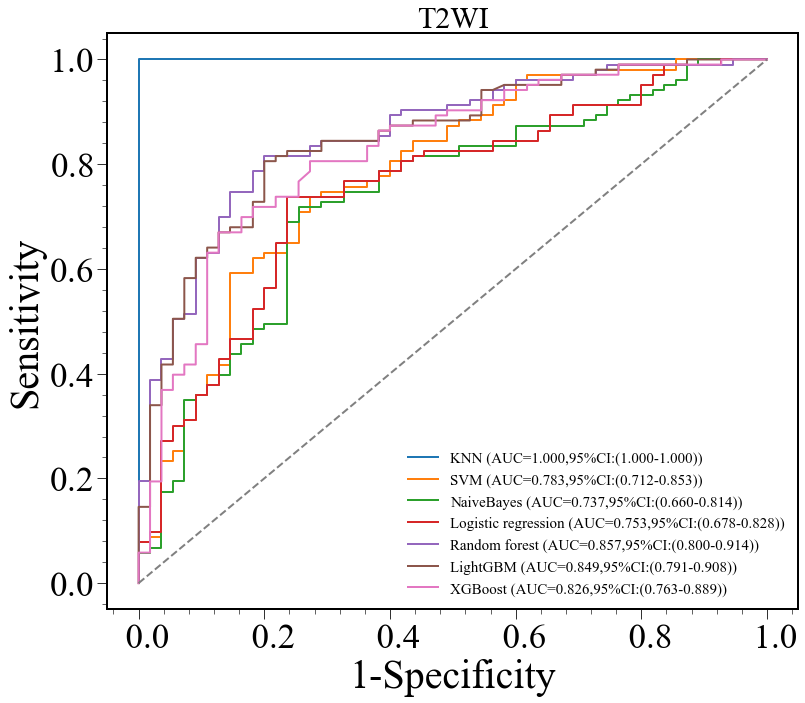

In [5]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(SSM2_KNN_true, SSM2_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(SSM2_SVM_true, SSM2_SVM_score[:,1], 'SVM', ax, positive=1)
roc_plot_inside(SSM2_NaiveBayes_true, SSM2_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(SSM2_LogisticRegression_true, SSM2_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(SSM2_RandomForest_true, SSM2_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(SSM2_LightGBM_true, SSM2_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(SSM2_XGBoost_true, SSM2_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
ax.set_title('T2WI', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/train_SSM2_ROC.png", dpi=300)

#### SSM3

In [6]:
SSM3_KNN = joblib.load(os.path.join(modeldir, 'KNN_SSM3.model')) 
SSM3_KNN_pred = SSM3_KNN.predict(SSM3_test_x)
SSM3_KNN_score = SSM3_KNN.predict_proba(SSM3_test_x)
SSM3_KNN_true = SSM3_test_y  #真实标签

SSM3_SVM = joblib.load(os.path.join(modeldir, 'SVM_SSM3.model')) 
SSM3_SVM_pred = SSM3_SVM.predict(SSM3_test_x)
SSM3_SVM_score = SSM3_SVM.predict_proba(SSM3_test_x)
SSM3_SVM_true = SSM3_test_y  #真实标签

SSM3_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_SSM3.model')) 
SSM3_NaiveBayes_pred = SSM3_NaiveBayes.predict(SSM3_test_x)
SSM3_NaiveBayes_score = SSM3_NaiveBayes.predict_proba(SSM3_test_x)
SSM3_NaiveBayes_true = SSM3_test_y  #真实标签

SSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_SSM3.model')) 
SSM3_LogisticRegression_pred = SSM3_LogisticRegression.predict(SSM3_test_x)
SSM3_LogisticRegression_score = SSM3_LogisticRegression.predict_proba(SSM3_test_x)
SSM3_LogisticRegression_true = SSM3_test_y  #真实标签

SSM3_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_SSM3.model')) 
SSM3_RandomForest_pred = SSM3_RandomForest.predict(SSM3_test_x)
SSM3_RandomForest_score = SSM3_RandomForest.predict_proba(SSM3_test_x)
SSM3_RandomForest_true = SSM3_test_y  #真实标签

SSM3_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_SSM3.model')) 
SSM3_LightGBM_pred = SSM3_LightGBM.predict(SSM3_test_x)
SSM3_LightGBM_score = SSM3_LightGBM.predict_proba(SSM3_test_x)
SSM3_LightGBM_true = SSM3_test_y  #真实标签

SSM3_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_SSM3.model')) 
SSM3_XGBoost_pred = SSM3_XGBoost.predict(SSM3_test_x)
SSM3_XGBoost_score = SSM3_XGBoost.predict_proba(SSM3_test_x)
SSM3_XGBoost_true = SSM3_test_y  #真实标签

<Figure size 864x720 with 0 Axes>

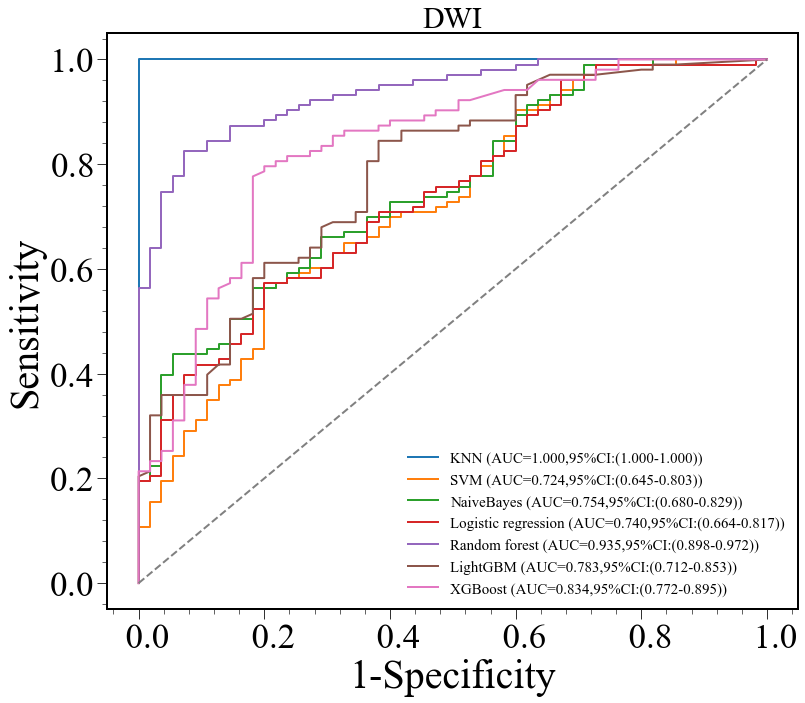

In [7]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(SSM3_KNN_true, SSM3_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(SSM3_SVM_true, SSM3_SVM_score[:,1], 'SVM', ax, positive=1)
roc_plot_inside(SSM3_NaiveBayes_true, SSM3_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(SSM3_LogisticRegression_true, SSM3_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(SSM3_RandomForest_true, SSM3_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(SSM3_LightGBM_true, SSM3_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(SSM3_XGBoost_true, SSM3_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
ax.set_title('DWI',fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Train_SSM3_ROC.png", dpi=300)

#### SSM4

In [8]:
SSM4_KNN = joblib.load(os.path.join(modeldir, 'KNN_SSM4.model')) 
SSM4_KNN_pred = SSM4_KNN.predict(SSM4_test_x)
SSM4_KNN_score = SSM4_KNN.predict_proba(SSM4_test_x)
SSM4_KNN_true = SSM4_test_y  #真实标签

SSM4_SVM = joblib.load(os.path.join(modeldir, 'SVM_SSM4.model')) 
SSM4_SVM_pred = SSM4_SVM.predict(SSM4_test_x)
SSM4_SVM_score = SSM4_SVM.predict_proba(SSM4_test_x)
SSM4_SVM_true = SSM4_test_y  #真实标签

SSM4_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_SSM4.model')) 
SSM4_NaiveBayes_pred = SSM4_NaiveBayes.predict(SSM4_test_x)
SSM4_NaiveBayes_score = SSM4_NaiveBayes.predict_proba(SSM4_test_x)
SSM4_NaiveBayes_true = SSM4_test_y  #真实标签

SSM4_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_SSM4.model')) 
SSM4_LogisticRegression_pred = SSM4_LogisticRegression.predict(SSM4_test_x)
SSM4_LogisticRegression_score = SSM4_LogisticRegression.predict_proba(SSM4_test_x)
SSM4_LogisticRegression_true = SSM4_test_y  #真实标签

SSM4_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_SSM4.model')) 
SSM4_RandomForest_pred = SSM4_RandomForest.predict(SSM4_test_x)
SSM4_RandomForest_score = SSM4_RandomForest.predict_proba(SSM4_test_x)
SSM4_RandomForest_true = SSM4_test_y  #真实标签

SSM4_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_SSM4.model')) 
SSM4_LightGBM_pred = SSM4_LightGBM.predict(SSM4_test_x)
SSM4_LightGBM_score = SSM4_LightGBM.predict_proba(SSM4_test_x)
SSM4_LightGBM_true = SSM4_test_y  #真实标签

SSM4_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_SSM4.model')) 
SSM4_XGBoost_pred = SSM4_XGBoost.predict(SSM4_test_x)
SSM4_XGBoost_score = SSM4_XGBoost.predict_proba(SSM4_test_x)
SSM4_XGBoost_true = SSM4_test_y  #真实标签

<Figure size 864x720 with 0 Axes>

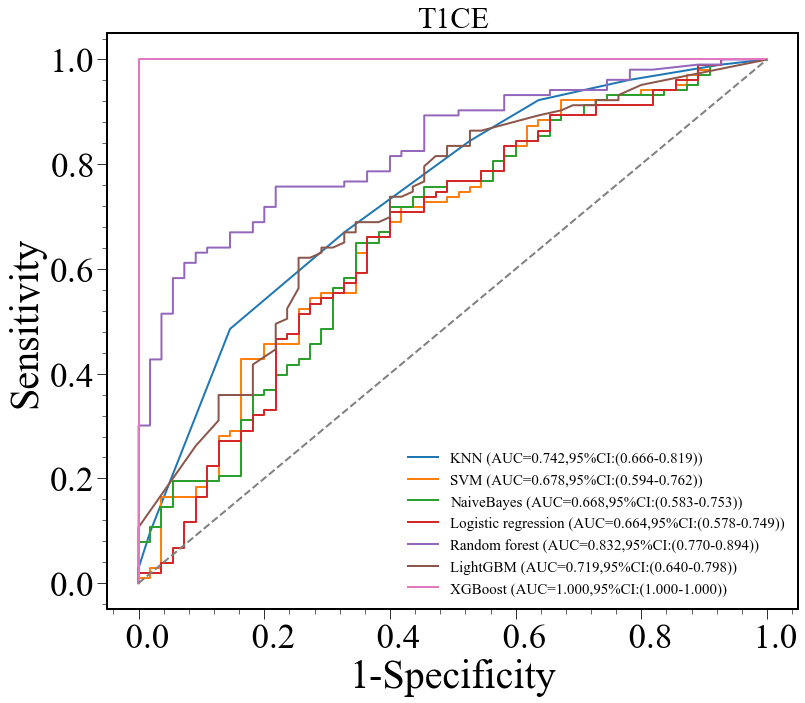

In [9]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(SSM4_KNN_true, SSM4_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(SSM4_SVM_true, SSM4_SVM_score[:,1], 'SVM', ax, positive=1)
roc_plot_inside(SSM4_NaiveBayes_true, SSM4_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(SSM4_LogisticRegression_true, SSM4_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(SSM4_RandomForest_true, SSM4_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(SSM4_LightGBM_true, SSM4_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(SSM4_XGBoost_true, SSM4_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
ax.set_title('T1CE',fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Train_SSM4_ROC.png", dpi=300)

#### DSM3

In [10]:
DSM3_KNN = joblib.load(os.path.join(modeldir, 'KNN_DSM3.model')) 
DSM3_KNN_pred = DSM3_KNN.predict(DSM3_test_x)
DSM3_KNN_score = DSM3_KNN.predict_proba(DSM3_test_x)
DSM3_KNN_true = DSM3_test_y  #真实标签

DSM3_SVM = joblib.load(os.path.join(modeldir, 'SVM_DSM3.model')) 
DSM3_SVM_pred = DSM3_SVM.predict(DSM3_test_x)
DSM3_SVM_score = DSM3_SVM.predict_proba(DSM3_test_x)
DSM3_SVM_true = DSM3_test_y  #真实标签

DSM3_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_DSM3.model')) 
DSM3_NaiveBayes_pred = DSM3_NaiveBayes.predict(DSM3_test_x)
DSM3_NaiveBayes_score = DSM3_NaiveBayes.predict_proba(DSM3_test_x)
DSM3_NaiveBayes_true = DSM3_test_y  #真实标签

DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_DSM3.model')) 
DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score = DSM3_LogisticRegression.predict_proba(DSM3_test_x)
DSM3_LogisticRegression_true = DSM3_test_y  #真实标签

DSM3_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
DSM3_RandomForest_pred = DSM3_RandomForest.predict(DSM3_test_x)
DSM3_RandomForest_score = DSM3_RandomForest.predict_proba(DSM3_test_x)
DSM3_RandomForest_true = DSM3_test_y  #真实标签

DSM3_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_DSM3.model')) 
DSM3_LightGBM_pred = DSM3_LightGBM.predict(DSM3_test_x)
DSM3_LightGBM_score = DSM3_LightGBM.predict_proba(DSM3_test_x)
DSM3_LightGBM_true = DSM3_test_y  #真实标签

DSM3_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_DSM3.model')) 
DSM3_XGBoost_pred = DSM3_XGBoost.predict(DSM3_test_x)
DSM3_XGBoost_score = DSM3_XGBoost.predict_proba(DSM3_test_x)
DSM3_XGBoost_true = DSM3_test_y  #真实标签

<Figure size 864x720 with 0 Axes>

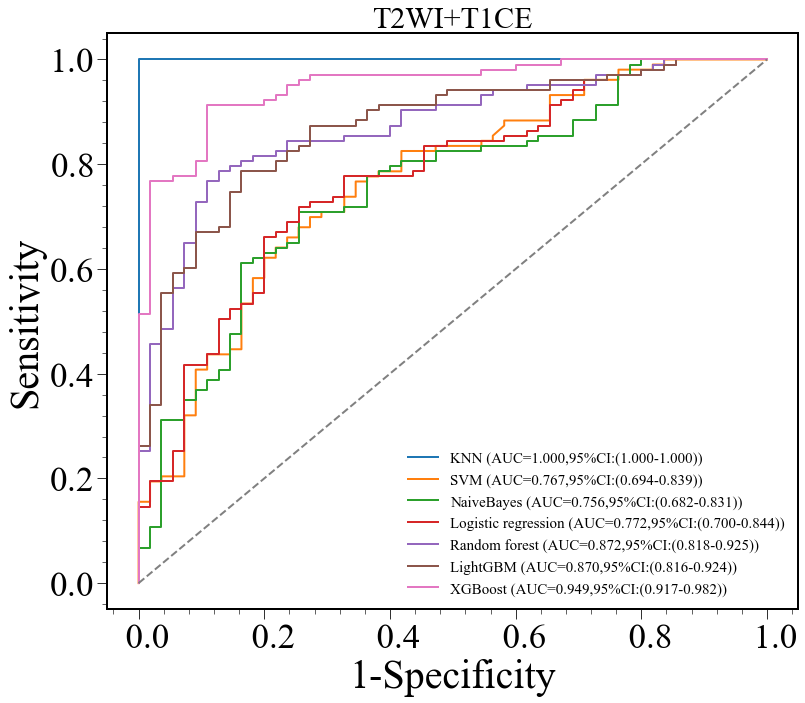

In [11]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(DSM3_KNN_true, DSM3_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(DSM3_SVM_true, DSM3_SVM_score[:,1], 'SVM', ax, positive=1)
roc_plot_inside(DSM3_NaiveBayes_true, DSM3_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(DSM3_LogisticRegression_true, DSM3_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(DSM3_RandomForest_true, DSM3_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(DSM3_LightGBM_true, DSM3_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(DSM3_XGBoost_true, DSM3_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
ax.set_title('T2WI+T1CE',fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Train_DSM3_ROC.png", dpi=300)

#### ASM

In [12]:
ASM_KNN = joblib.load(os.path.join(modeldir, 'KNN_ASM.model')) 
ASM_KNN_pred = ASM_KNN.predict(ASM_test_x)
ASM_KNN_score = ASM_KNN.predict_proba(ASM_test_x)
ASM_KNN_true = ASM_test_y  #真实标签

ASM_SVM = joblib.load(os.path.join(modeldir, 'SVM_ASM.model')) 
ASM_SVM_pred = ASM_SVM.predict(ASM_test_x)
ASM_SVM_score = ASM_SVM.predict_proba(ASM_test_x)
ASM_SVM_true = ASM_test_y  #真实标签

ASM_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_ASM.model')) 
ASM_NaiveBayes_pred = ASM_NaiveBayes.predict(ASM_test_x)
ASM_NaiveBayes_score = ASM_NaiveBayes.predict_proba(ASM_test_x)
ASM_NaiveBayes_true = ASM_test_y  #真实标签

ASM_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_ASM.model')) 
ASM_LogisticRegression_pred = ASM_LogisticRegression.predict(ASM_test_x)
ASM_LogisticRegression_score = ASM_LogisticRegression.predict_proba(ASM_test_x)
ASM_LogisticRegression_true = ASM_test_y  #真实标签

ASM_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_ASM.model')) 
ASM_RandomForest_pred = ASM_RandomForest.predict(ASM_test_x)
ASM_RandomForest_score = ASM_RandomForest.predict_proba(ASM_test_x)
ASM_RandomForest_true = ASM_test_y  #真实标签

ASM_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_ASM.model')) 
ASM_LightGBM_pred = ASM_LightGBM.predict(ASM_test_x)
ASM_LightGBM_score = ASM_LightGBM.predict_proba(ASM_test_x)
ASM_LightGBM_true = ASM_test_y  #真实标签

ASM_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_ASM.model')) 
ASM_XGBoost_pred = ASM_XGBoost.predict(ASM_test_x)
ASM_XGBoost_score = ASM_XGBoost.predict_proba(ASM_test_x)
ASM_XGBoost_true = ASM_test_y  #真实标签

<Figure size 864x720 with 0 Axes>

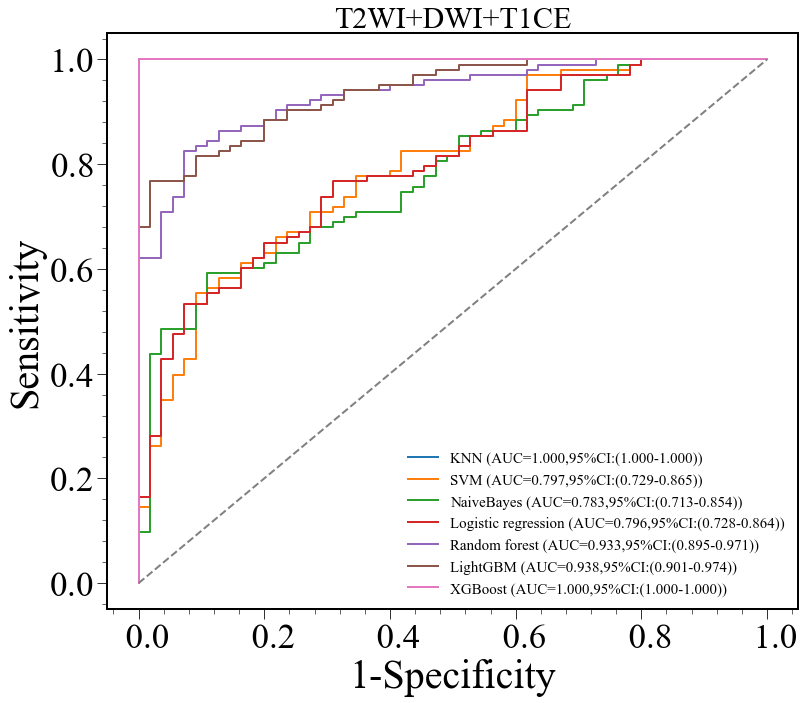

In [13]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(ASM_KNN_true, ASM_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(ASM_SVM_true, ASM_SVM_score[:,1], 'SVM', ax, positive=1)
roc_plot_inside(ASM_NaiveBayes_true, ASM_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(ASM_LogisticRegression_true, ASM_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(ASM_RandomForest_true, ASM_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(ASM_LightGBM_true, ASM_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(ASM_XGBoost_true, ASM_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
ax.set_title('T2WI+DWI+T1CE', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Train_ASM_ROC.png", dpi=300)

#### Clinical

In [90]:
Clinical_KNN = joblib.load(os.path.join(modeldir, 'KNN_Clinical.model')) 
Clinical_KNN_pred = Clinical_KNN.predict(Clinical_test_x)
Clinical_KNN_score = Clinical_KNN.predict_proba(Clinical_test_x)
Clinical_KNN_true = Clinical_test_y  #真实标签

Clinical_SVM = joblib.load(os.path.join(modeldir, 'SVM_Clinical.model')) 
Clinical_SVM_pred = Clinical_SVM.predict(Clinical_test_x)
Clinical_SVM_score = Clinical_SVM.predict_proba(Clinical_test_x)
Clinical_SVM_true = Clinical_test_y  #真实标签

Clinical_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_Clinical.model')) 
Clinical_NaiveBayes_pred = Clinical_NaiveBayes.predict(Clinical_test_x)
Clinical_NaiveBayes_score = Clinical_NaiveBayes.predict_proba(Clinical_test_x)
Clinical_NaiveBayes_true = Clinical_test_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_clinical.model')) 
Clinical_LogisticRegression_pred = Clinical_LogisticRegression.predict(Clinical_test_x)
Clinical_LogisticRegression_score = Clinical_LogisticRegression.predict_proba(Clinical_test_x)
Clinical_LogisticRegression_true = Clinical_test_y

Clinical_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_Clinical.model')) 
Clinical_RandomForest_pred = Clinical_RandomForest.predict(Clinical_test_x)
Clinical_RandomForest_score = Clinical_RandomForest.predict_proba(Clinical_test_x)
Clinical_RandomForest_true = Clinical_test_y  #真实标签

Clinical_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_Clinical.model')) 
Clinical_LightGBM_pred = Clinical_LightGBM.predict(Clinical_test_x)
Clinical_LightGBM_score = Clinical_LightGBM.predict_proba(Clinical_test_x)
Clinical_LightGBM_true = Clinical_test_y  #真实标签

Clinical_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_Clinical.model')) 
Clinical_XGBoost_pred = Clinical_XGBoost.predict(Clinical_test_x)
Clinical_XGBoost_score = Clinical_XGBoost.predict_proba(Clinical_test_x)
Clinical_XGBoost_true = Clinical_test_y  #真实标签

In [91]:
print(Clinical_LogisticRegression_pred)
print(Clinical_LogisticRegression_true.values)

[0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1
 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1
 1 1 1 0 1 1 0 1 1 0]
[1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0
 1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1
 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1
 1 1 1 0 0 1 1 1 0 0]


<Figure size 864x720 with 0 Axes>

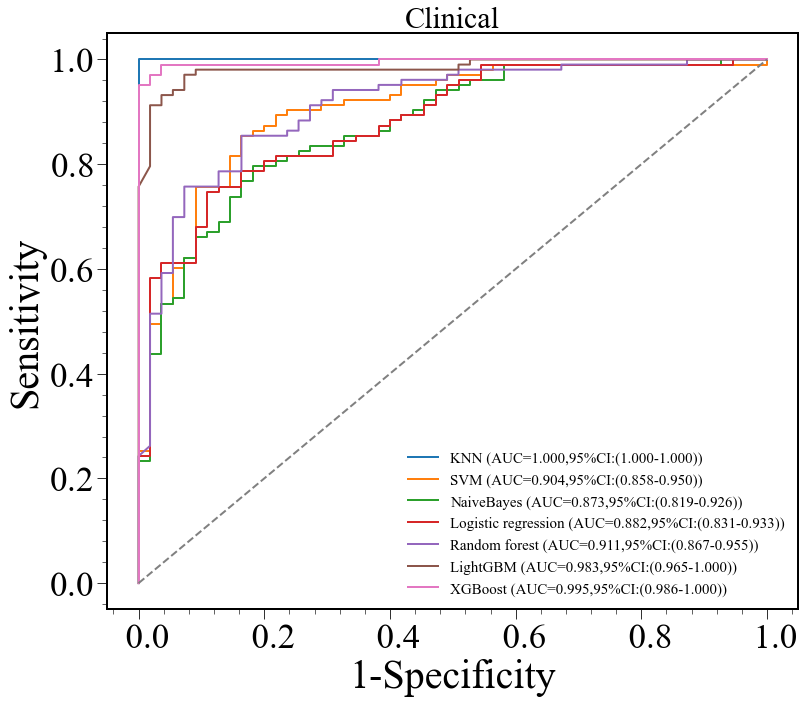

In [92]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(Clinical_KNN_true, Clinical_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(Clinical_SVM_true, Clinical_SVM_score[:,1], 'SVM', ax, positive=1)
roc_plot_inside(Clinical_NaiveBayes_true, Clinical_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(Clinical_LogisticRegression_true, Clinical_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(Clinical_RandomForest_true, Clinical_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(Clinical_LightGBM_true, Clinical_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(Clinical_XGBoost_true, Clinical_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
ax.set_title('Clinical', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Train_Clinical_ROC.png", dpi=300)

#### Clinical+T1CE+T2WI

In [93]:
CDSM_KNN = joblib.load(os.path.join(modeldir, 'KNN_CDSM.model')) 
CDSM_test_x = np.array([DSM3_KNN_score[:,1], Clinical_KNN_score[:, 1]]).T
CDSM_KNN_pred = CDSM_KNN.predict(CDSM_test_x)
CDSM_KNN_score = CDSM_KNN.predict_proba(CDSM_test_x)
CDSM_KNN_true = DSM3_test_y  #真实标签

CDSM_SVM = joblib.load(os.path.join(modeldir, 'SVM_CDSM.model')) 
CDSM_test_x = np.array([DSM3_SVM_score[:,1], Clinical_SVM_score[:, 1]]).T
CDSM_SVM_pred = CDSM_SVM.predict(CDSM_test_x)
CDSM_SVM_score = CDSM_SVM.predict_proba(CDSM_test_x)
CDSM_SVM_true = DSM3_test_y  #真实标签

CDSM_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_CDSM.model')) 
CDSM_test_x = np.array([DSM3_NaiveBayes_score[:,1], Clinical_NaiveBayes_score[:, 1]]).T
CDSM_NaiveBayes_pred = CDSM_NaiveBayes.predict(CDSM_test_x)
CDSM_NaiveBayes_score = CDSM_NaiveBayes.predict_proba(CDSM_test_x)
CDSM_NaiveBayes_true = DSM3_test_y   #真实标签

CDSM_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_CDSM.model')) 
CDSM_test_x = np.array([DSM3_LogisticRegression_score[:,1], Clinical_LogisticRegression_score[:, 1]]).T
CDSM_LogisticRegression_pred = CDSM_LogisticRegression.predict(CDSM_test_x)
CDSM_LogisticRegression_score = CDSM_LogisticRegression.predict_proba(CDSM_test_x)
CDSM_LogisticRegression_true = DSM3_test_y  #真实标签

CDSM_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_CDSM.model')) 
CDSM_test_x = np.array([DSM3_RandomForest_score[:,1], Clinical_RandomForest_score[:, 1]]).T
CDSM_RandomForest_pred = CDSM_RandomForest.predict(CDSM_test_x)
CDSM_RandomForest_score = CDSM_RandomForest.predict_proba(CDSM_test_x)
CDSM_RandomForest_true = DSM3_test_y   #真实标签

CDSM_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_CDSM.model')) 
CDSM_test_x = np.array([DSM3_LightGBM_score[:,1], Clinical_LightGBM_score[:, 1]]).T
CDSM_LightGBM_pred = CDSM_LightGBM.predict(CDSM_test_x)
CDSM_LightGBM_score = CDSM_LightGBM.predict_proba(CDSM_test_x)
CDSM_LightGBM_true = DSM3_test_y  #真实标签

CDSM_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_CDSM.model')) 
CDSM_test_x = np.array([DSM3_XGBoost_score[:,1], Clinical_XGBoost_score[:, 1]]).T
CDSM_XGBoost_pred = CDSM_XGBoost.predict(CDSM_test_x)
CDSM_XGBoost_score = CDSM_XGBoost.predict_proba(CDSM_test_x)
CDSM_XGBoost_true = DSM3_test_y  #真实标签

<Figure size 864x720 with 0 Axes>

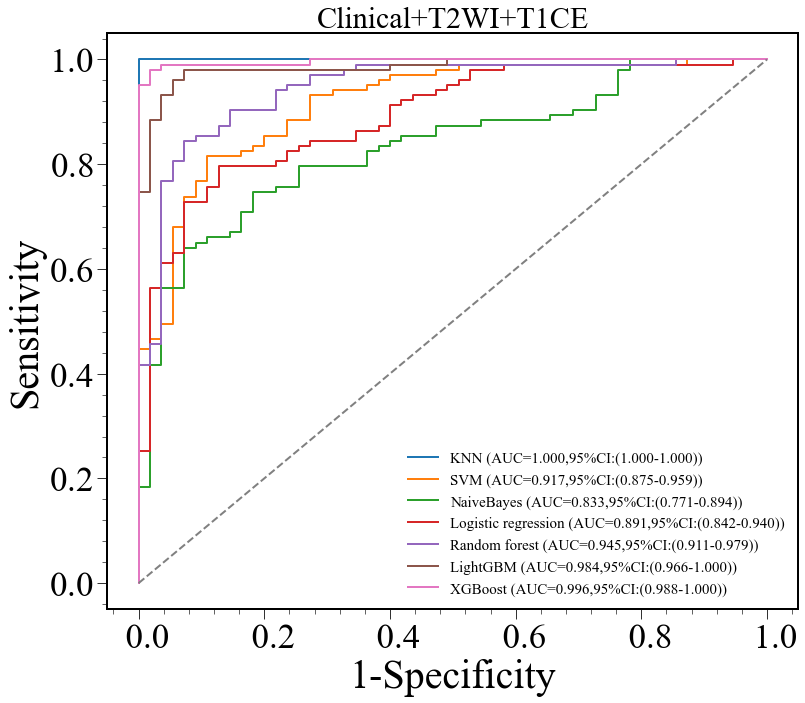

In [94]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(CDSM_KNN_true, CDSM_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(CDSM_SVM_true, CDSM_SVM_score[:,1], 'SVM', ax, positive=1)
roc_plot_inside(CDSM_NaiveBayes_true, CDSM_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(CDSM_LogisticRegression_true, CDSM_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(CDSM_RandomForest_true, CDSM_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(CDSM_LightGBM_true, CDSM_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(CDSM_XGBoost_true, CDSM_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
ax.set_title('Clinical+T2WI+T1CE', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Train_CDSM_ROC.png", dpi=300)

### Evaluation for train data use logistics

In [95]:
def specificity_score(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    specificity = TN/(TN+FP)
    return specificity

def classification_evaluation(y_true, y_pred, y_score):
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_score)
    f1 = metrics.f1_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    evaluation = {'accuracy':accuracy, 'recall':recall, 'precision':precision, 'f1':f1, 'auc':auc, 'specificity':specificity}
    return evaluation

In [103]:
logistic_eva_cr = classification_evaluation(CDSM_LogisticRegression_true, CDSM_LogisticRegression_pred,CDSM_LogisticRegression_score[:,1])
XGBoost_eva_cr = classification_evaluation(CDSM_XGBoost_true, CDSM_XGBoost_pred,CDSM_XGBoost_score[:,1])
XGBoost_eva_r = classification_evaluation(DSM3_XGBoost_true, DSM3_XGBoost_pred,DSM3_XGBoost_score[:,1])
XGBoost_eva_c = classification_evaluation(Clinical_XGBoost_true, Clinical_XGBoost_pred,Clinical_XGBoost_score[:,1])
print(XGBoost_eva_r)
print(XGBoost_eva_c)
print(XGBoost_eva_cr)

{'accuracy': 0.8481012658227848, 'recall': 0.970873786407767, 'precision': 0.8264462809917356, 'f1': 0.8928571428571429, 'auc': 0.9491615180935569, 'specificity': 0.6181818181818182}
{'accuracy': 0.9556962025316456, 'recall': 0.9320388349514563, 'precision': 1.0, 'f1': 0.9648241206030151, 'auc': 0.9952338923212709, 'specificity': 1.0}
{'accuracy': 0.9746835443037974, 'recall': 0.9805825242718447, 'precision': 0.9805825242718447, 'f1': 0.9805825242718447, 'auc': 0.9964695498676082, 'specificity': 0.9636363636363636}


#### External: Clinical+T1CE+T2WI

In [151]:
# DSM
exdf_DSM = pd.read_csv(os.path.join(testdir, 'DSM_test_external.csv'))
# Train data
standardscaler = StandardScaler()
# Test data
exDSM_test_y = exdf_DSM['label'] 
exDSM_test_x = exdf_DSM.drop(Dtag_cols, axis=1)
exDSM_test_x = standardscaler.fit_transform(exDSM_test_x) 
exDSM3_test_y = exDSM_test_y.to_list() 
exDSM3_test_x = exDSM_test_x

# Clinical
# Load the Clinical features.
exClinical_test = pd.read_csv(os.path.join(testdir, 'clinical_test_external.csv')) 
# Train data
standardscaler = StandardScaler()
# Test data
# exClinical_test = exClinical_test.sample(frac=1.0, random_state=random_state)
exClinical_test_y = exClinical_test['label']
exClinical_test_y = exClinical_test_y.to_list()
exClinical_test_x =exClinical_test.drop(Dtag_cols, axis=1)
exClinical_test_x = standardscaler.fit_transform(exClinical_test_x)
print(exDSM3_test_y)
print(len(exClinical_test_y))

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]
45


In [152]:
exDSM3_KNN = joblib.load(os.path.join(modeldir, 'KNN_DSM3.model')) 
exDSM3_KNN_pred = exDSM3_KNN.predict(exDSM3_test_x)
exDSM3_KNN_score = exDSM3_KNN.predict_proba(exDSM3_test_x)
exDSM3_KNN_true = exDSM3_test_y  #真实标签

exDSM3_SVM = joblib.load(os.path.join(modeldir, 'SVM_DSM3.model')) 
exDSM3_SVM_pred = exDSM3_SVM.predict(exDSM3_test_x)
exDSM3_SVM_score = exDSM3_SVM.predict_proba(exDSM3_test_x)
exDSM3_SVM_true = exDSM3_test_y  #真实标签

exDSM3_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_DSM3.model')) 
exDSM3_NaiveBayes_pred = exDSM3_NaiveBayes.predict(exDSM3_test_x)
exDSM3_NaiveBayes_score = exDSM3_NaiveBayes.predict_proba(exDSM3_test_x)
exDSM3_NaiveBayes_true = exDSM3_test_y  #真实标签

exDSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_DSM3.model')) 
exDSM3_LogisticRegression_pred = exDSM3_LogisticRegression.predict(exDSM3_test_x)
exDSM3_LogisticRegression_score = exDSM3_LogisticRegression.predict_proba(exDSM3_test_x)
exDSM3_LogisticRegression_true = exDSM3_test_y  #真实标签

exDSM3_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
exDSM3_RandomForest_pred = exDSM3_RandomForest.predict(exDSM3_test_x)
exDSM3_RandomForest_score = exDSM3_RandomForest.predict_proba(exDSM3_test_x)
exDSM3_RandomForest_true = exDSM3_test_y  #真实标签

exDSM3_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_DSM3.model')) 
exDSM3_LightGBM_pred = exDSM3_LightGBM.predict(exDSM3_test_x)
exDSM3_LightGBM_score = exDSM3_LightGBM.predict_proba(exDSM3_test_x)
exDSM3_LightGBM_true = exDSM3_test_y  #真实标签

exDSM3_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_DSM3.model')) 
exDSM3_XGBoost_pred = exDSM3_XGBoost.predict(exDSM3_test_x)
exDSM3_XGBoost_score = exDSM3_XGBoost.predict_proba(exDSM3_test_x)
exDSM3_XGBoost_true = exDSM3_test_y  #真实标签
print(exDSM3_test_y)

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]


In [153]:
exClinical_KNN = joblib.load(os.path.join(modeldir, 'KNN_Clinical.model')) 
exClinical_KNN_pred = exClinical_KNN.predict(exClinical_test_x)
exClinical_KNN_score = exClinical_KNN.predict_proba(exClinical_test_x)
exClinical_KNN_true = exClinical_test_y  #真实标签

exClinical_SVM = joblib.load(os.path.join(modeldir, 'SVM_Clinical.model')) 
exClinical_SVM_pred = exClinical_SVM.predict(exClinical_test_x)
exClinical_SVM_score = exClinical_SVM.predict_proba(exClinical_test_x)
exClinical_SVM_true = exClinical_test_y  #真实标签

exClinical_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_Clinical.model')) 
exClinical_NaiveBayes_pred = exClinical_NaiveBayes.predict(exClinical_test_x)
exClinical_NaiveBayes_score = exClinical_NaiveBayes.predict_proba(exClinical_test_x)
exClinical_NaiveBayes_true = exClinical_test_y  #真实标签

exClinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_clinical.model')) 
exClinical_LogisticRegression_pred = exClinical_LogisticRegression.predict(exClinical_test_x)
exClinical_LogisticRegression_score = exClinical_LogisticRegression.predict_proba(exClinical_test_x)
exClinical_LogisticRegression_true = exClinical_test_y  #真实标签

exClinical_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_Clinical.model')) 
exClinical_RandomForest_pred = exClinical_RandomForest.predict(exClinical_test_x)
exClinical_RandomForest_score = exClinical_RandomForest.predict_proba(exClinical_test_x)
exClinical_RandomForest_true = exClinical_test_y  #真实标签

exClinical_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_Clinical.model')) 
exClinical_LightGBM_pred = exClinical_LightGBM.predict(exClinical_test_x)
exClinical_LightGBM_score = exClinical_LightGBM.predict_proba(exClinical_test_x)
exClinical_LightGBM_true = exClinical_test_y  #真实标签

exClinical_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_Clinical.model')) 
exClinical_XGBoost_pred = exClinical_XGBoost.predict(exClinical_test_x)
exClinical_XGBoost_score = exClinical_XGBoost.predict_proba(exClinical_test_x)
exClinical_XGBoost_true = exClinical_test_y  #真实标签
print(exClinical_extest_y)

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]


In [154]:
exCDSM_KNN = joblib.load(os.path.join(modeldir, 'KNN_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_KNN_score[:,1], exClinical_KNN_score[:, 1]]).T
exCDSM_KNN_pred = exCDSM_KNN.predict(exCDSM_test_x)
exCDSM_KNN_score = exCDSM_KNN.predict_proba(exCDSM_test_x)
exCDSM_KNN_true = exClinical_test_y  #真实标签

exCDSM_SVM = joblib.load(os.path.join(modeldir, 'SVM_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_SVM_score[:,1], exClinical_SVM_score[:, 1]]).T
exCDSM_SVM_pred = exCDSM_SVM.predict(exCDSM_test_x)
exCDSM_SVM_score = exCDSM_SVM.predict_proba(exCDSM_test_x)
exCDSM_SVM_true = exClinical_test_y  #真实标签

exCDSM_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_NaiveBayes_score[:,1], exClinical_NaiveBayes_score[:, 1]]).T
exCDSM_NaiveBayes_pred = exCDSM_NaiveBayes.predict(exCDSM_test_x)
exCDSM_NaiveBayes_score = exCDSM_NaiveBayes.predict_proba(exCDSM_test_x)
exCDSM_NaiveBayes_true = exClinical_test_y   #真实标签

exCDSM_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_LogisticRegression_score[:,1], exClinical_LogisticRegression_score[:, 1]]).T
exCDSM_LogisticRegression_pred = exCDSM_LogisticRegression.predict(exCDSM_test_x)
exCDSM_LogisticRegression_score = exCDSM_LogisticRegression.predict_proba(exCDSM_test_x)
exCDSM_LogisticRegression_true = exClinical_test_y  #真实标签

exCDSM_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_RandomForest_score[:,1], exClinical_RandomForest_score[:, 1]]).T
exCDSM_RandomForest_pred = exCDSM_RandomForest.predict(exCDSM_test_x)
exCDSM_RandomForest_score = exCDSM_RandomForest.predict_proba(exCDSM_test_x)
exCDSM_RandomForest_true = exClinical_test_y   #真实标签

exCDSM_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_LightGBM_score[:,1], exClinical_LightGBM_score[:, 1]]).T
exCDSM_LightGBM_pred = exCDSM_LightGBM.predict(exCDSM_test_x)
exCDSM_LightGBM_score = exCDSM_LightGBM.predict_proba(exCDSM_test_x)
exCDSM_LightGBM_true = exClinical_test_y  #真实标签

exCDSM_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_XGBoost_score[:,1], exClinical_XGBoost_score[:, 1]]).T
exCDSM_XGBoost_pred = exCDSM_XGBoost.predict(exCDSM_test_x)
exCDSM_XGBoost_score = exCDSM_XGBoost.predict_proba(exCDSM_test_x)
exCDSM_XGBoost_true = exClinical_test_y  #真实标签

<Figure size 864x720 with 0 Axes>

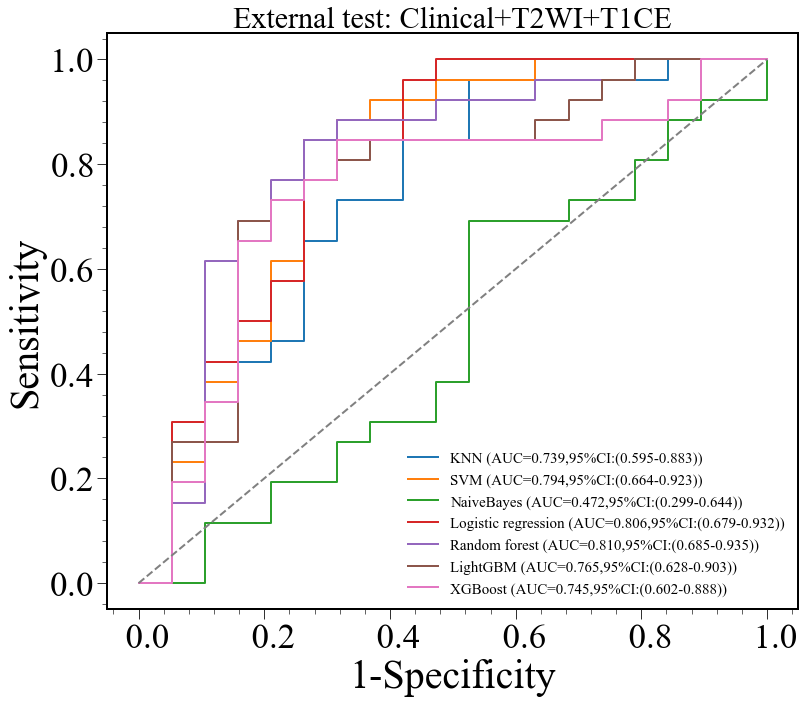

In [155]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(exCDSM_KNN_true, exCDSM_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(exCDSM_SVM_true, exCDSM_SVM_score[:,1], 'SVM', ax, positive=1)
roc_plot_inside(exCDSM_NaiveBayes_true, exCDSM_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(exCDSM_LogisticRegression_true, exCDSM_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(exCDSM_RandomForest_true, exCDSM_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(exCDSM_LightGBM_true, exCDSM_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(exCDSM_XGBoost_true, exCDSM_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
ax.set_title('External test: Clinical+T2WI+T1CE', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/external_CDSM_ROC.png", dpi=300)

### 绘制ROC图表

#### SSM2 ROC

In [82]:
model_forest = joblib.load(os.path.join(modeldir, 'model_forest0.model')) #这是自己训练模型，记得替换自己的。
predict_label = model_forest.predict(rforest_test_x) #预测的标签
y_predict = model_forest.predict_proba(rforest_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
label = rforest_test_y.to_list()  #真实标签

<Figure size 864x720 with 0 Axes>

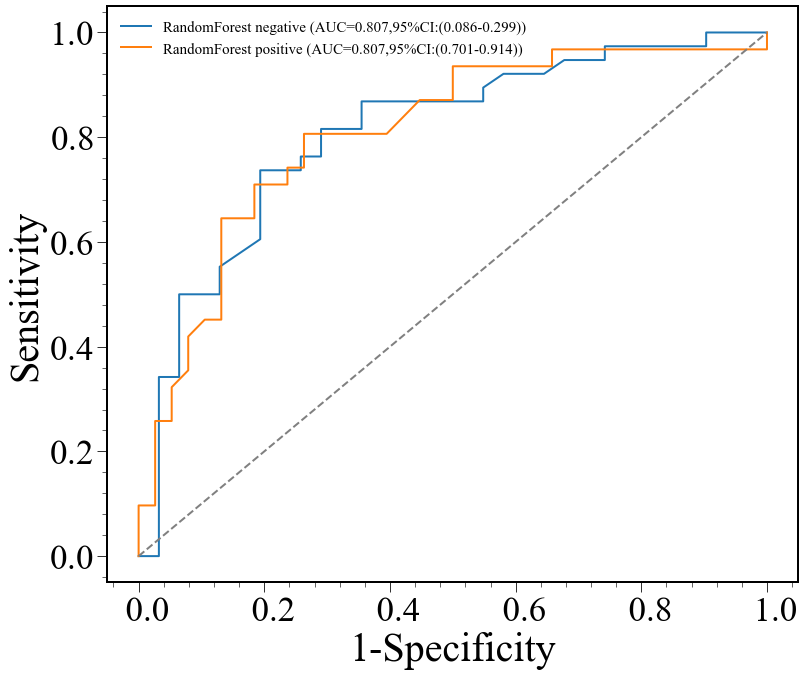

In [92]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

roc_plot_inside(label, y_predict[:,0], 'RandomForest negative', ax, positive=0)
roc_plot_inside(label, y_predict[:,1], 'RandomForest positive', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./Data/IMG/ROC.png", dpi=300)

### 绘制PR curve

/home/tx-deepocean/anaconda3/envs/python3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


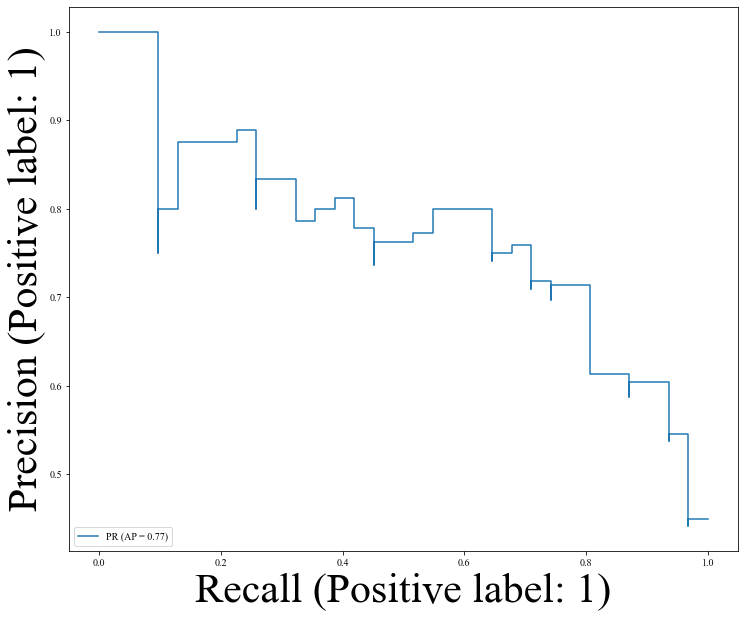

In [90]:
#绘制PR曲线，一行代码
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(model_forest, rforest_test_x, rforest_test_y,name='PR',pos_label=1)

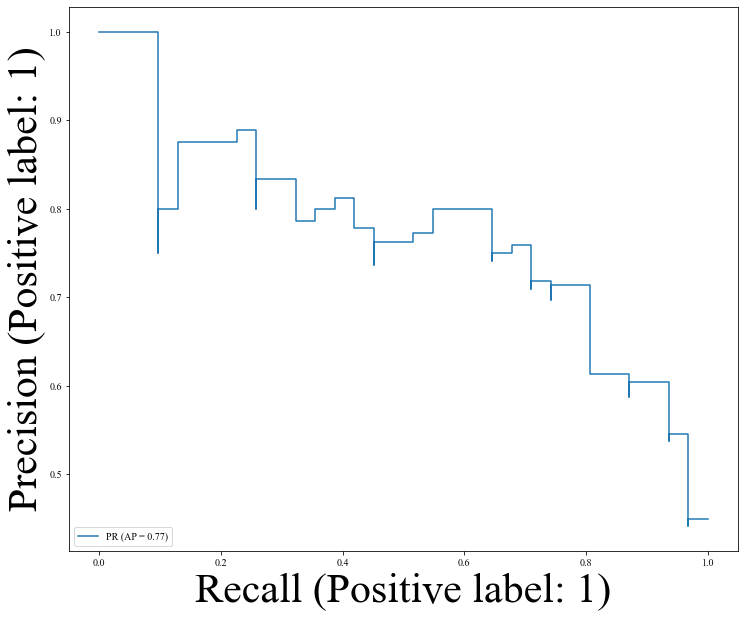

In [91]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(model_forest, rforest_test_x, rforest_test_y,name='PR',pos_label=1)

In [95]:
import sklearn
dir(sklearn.metrics)

['ConfusionMatrixDisplay',
 'DetCurveDisplay',
 'DistanceMetric',
 'PrecisionRecallDisplay',
 'RocCurveDisplay',
 'SCORERS',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_base',
 '_classification',
 '_dist_metrics',
 '_pairwise_fast',
 '_plot',
 '_ranking',
 '_regression',
 '_scorer',
 'accuracy_score',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'auc',
 'average_precision_score',
 'balanced_accuracy_score',
 'brier_score_loss',
 'calinski_harabasz_score',
 'check_scoring',
 'classification_report',
 'cluster',
 'cohen_kappa_score',
 'completeness_score',
 'confusion_matrix',
 'consensus_score',
 'coverage_error',
 'd2_tweedie_score',
 'davies_bouldin_score',
 'dcg_score',
 'det_curve',
 'euclidean_distances',
 'explained_variance_score',
 'f1_score',
 'fbeta_score',
 'fowlkes_mallows_score',
 'get_scorer',
 'hamming_loss',
 'hinge_loss',
 'homogeneity_completeness_v_measure',
 '